In [15]:
import pandas as pd
import redis

# get timestamps
r = redis.Redis()
timestamps = r.zrange("drone:timestamps", 0, -1, withscores=True)

# DataFrame
data = []
for ts, _ in timestamps:
    state = r.hgetall(f"drone:state:{ts.decode()}")
    data.append({k.decode(): float(v) for k, v in state.items()})

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

In [16]:
motor_stats = df[['motor1', 'motor2', 'motor3', 'motor4']].describe()
print(motor_stats)

motor_corr = df[['motor1', 'motor2', 'motor3', 'motor4']].corr()

            motor1       motor2       motor3       motor4
count  1001.000000  1001.000000  1001.000000  1001.000000
mean     15.781077    15.781077    15.781077    15.781077
std       0.000933     0.000933     0.000933     0.000933
min      15.780465    15.780465    15.780465    15.780465
25%      15.780465    15.780465    15.780465    15.780465
50%      15.780465    15.780465    15.780465    15.780465
75%      15.782500    15.782500    15.782500    15.782500
max      15.782500    15.782500    15.782500    15.782500


In [17]:
from scipy.spatial.transform import Rotation
quaternions = df[['q_w', 'q_x', 'q_y', 'q_z']].values
euler_angles = Rotation.from_quat(quaternions).as_euler('xyz', degrees=True)
df[['roll', 'pitch', 'yaw']] = euler_angles

angle_stats = df[['roll', 'pitch', 'yaw']].describe()
print(angle_stats)

              roll        pitch          yaw
count  1001.000000  1001.000000  1001.000000
mean      6.255079    -0.086197     0.420123
std     170.617912    11.253462    11.343007
min    -179.992374   -33.600779   -31.213810
25%    -171.246304    -7.824662    -7.418425
50%     155.418753    -0.000036    -0.453685
75%     172.542383     7.659463     8.207706
max     180.000000    33.272023    36.940267


In [18]:
from scipy.fft import fft
import numpy as np

motor1_fft = np.abs(fft(df['motor1'].values))
frequencies = np.fft.fftfreq(len(df), d=0.01)
print(frequencies)

[ 0.         0.0999001  0.1998002 ... -0.2997003 -0.1998002 -0.0999001]


In [22]:
import pandas as pd
import redis
import matplotlib.pyplot as plt
import seaborn as sns

r = redis.Redis(host='localhost', port=6379, db=0)

timestamps = [ts.decode() for ts in r.zrange("drone:timestamps", 0, -1)]

motor_data = []
for ts in timestamps:
    state = r.hgetall(f"drone:state:{ts}")
    motor_data.append({
        'motor1': float(state[b'motor1']),
        'motor2': float(state[b'motor2']),
        'motor3': float(state[b'motor3']),
        'motor4': float(state[b'motor4'])
    })

df_motors = pd.DataFrame(motor_data)

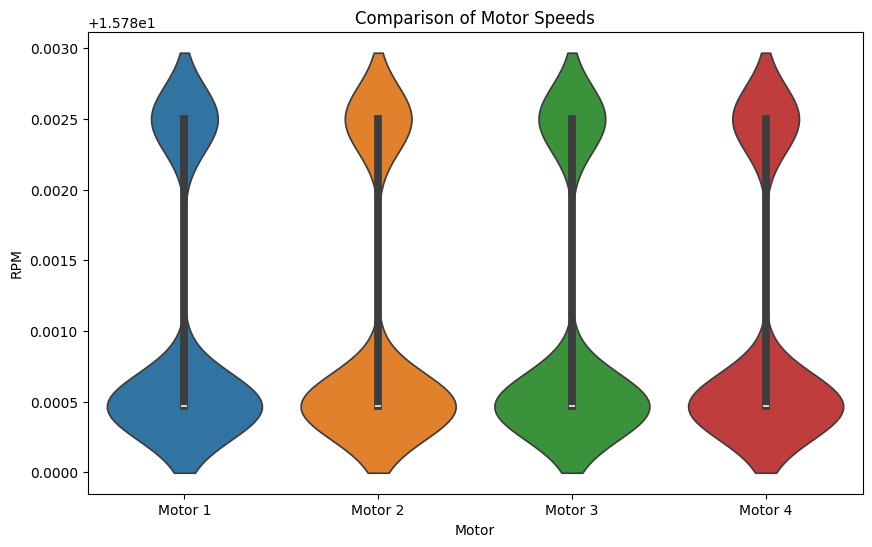

In [23]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_motors, palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Comparison of Motor Speeds')
plt.ylabel('RPM')
plt.xlabel('Motor')
plt.xticks([0, 1, 2, 3], ['Motor 1', 'Motor 2', 'Motor 3', 'Motor 4'])
plt.show()